# **06장. 2개의 층을 연결합니다 - 다층 신경망**

In [15]:
import numpy as np
import matplotlib.pyplot as plt

In [16]:
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split

cancer = load_breast_cancer()
x = cancer.data
y = cancer.target
x_train_all, x_test, y_train_all, y_test = train_test_split(x, y, stratify=y, test_size=0.2, random_state=42)
x_train, x_val, y_train, y_val = train_test_split(x_train_all, y_train_all, stratify=y_train_all, test_size=0.2, random_state=42)

print(x_train.shape, x_val.shape)

(364, 30) (91, 30)


In [17]:
#배치 경사 하강법 (<-> 확률 경사 하강법)
class SingleLayer :
  def __init__(self, learning_rate=0.1, l1=0, l2=0) :
    self.w = None
    self.b = None
    self.losses = []
    self.w_history = []
    self.lr = learning_rate
    self.val_losses = []
    self.l1 = l1
    self.l2 = l2

  def forpass(self, x) :
    z = np.dot(x, self.w) + self.b #x1*w1 + x2*w2 + ... + b (점곱 계산)
    return z

  def backprop(self, x, err) :
    m = len(x) #샘플 수
    w_grad = np.dot(x.T, err) / m #x 전치하여 특성*오차/샘플수 = 그레이디언트 평균값
    b_grad = np.sum(err) / m
    return w_grad, b_grad

  def activation(self, z) :
    a = 1 / (1 + np.exp(-z))
    return a


  def fit(self, x, y, epochs=100, x_val=None, y_val=None) :
    y = y.reshape(-1,1) #타깃을 행->열 벡터로 바꿈
    y_val = y_val.reshape(-1,1)
    m = len(x)
    self.w = np.ones((x.shape[1], 1))
    self.b = 0
    self.w_history.append(self.w.copy())
    #epoch만큼 반복
    for i in range(epochs) :
      z = self.forpass(x)
      a = self.activation(z)
      err = -(y - a)
      w_grad, b_grad = self.backprop(x, err)
      w_grad += (self.l1 * np.sign(self.w) + self.l2 * self.w) / m
      self.w -= self.lr * w_grad
      self.b -= self.lr * b_grad

      self.w_history.append(self.w.copy())
      a = np.clip(a, 1e-10, 1-1e-10)
      loss = np.sum(-(y*np.log(a) + (1-y)*np.log(1-a)))
      self.losses.append((loss + self.reg_loss()) / m)

      self.update_val_loss(x_val, y_val)



  def predict(self, x) :
    z = self.forpass(x)
    return z > 0

  def score(self, x, y) :
    return np.mean(self.predict(x) == y.reshape(-1,1))

  def update_val_loss(self, x_val, y_val) :
    z = self.forpass(x_val)
    a = self.activation(z)
    a = np.clip(a, 1e-10, 1-1e-10)

    val_loss = np.sum(-(y_val*np.log(a) + (1-y_val)*np.log(1-a)))
    self.val_losses.append( ((val_loss + self.reg_loss())) / len(y_val) )

  def reg_loss(self) :
    return self.l1 * np.sum(np.abs(self.w) + self.l2 / 2 * np.sum(self.w**2))

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler() #표준화 전처리 클래스 객체 생성
scaler.fit(x_train) #훈련 세트에 대하여 전처리 규칙 익힘
x_train_scaled = scaler.transform(x_train) #훈련세트 표준화 적용
x_val_scaled = scaler.transform(x_val) #검증세트 표준화 적용

In [19]:
#배치 경사 하강법 실행
single_layer = SingleLayer(l2=0.01)
single_layer.fit(x_train_scaled, y_train, x_val=x_val_scaled, y_val=y_val, epochs=10000)
#에포크를 늘린 이유: 확률적 경사 하강법보다 가중치 수정 횟수가 적기 때문
single_layer.score(x_val_scaled, y_val)

np.float64(0.978021978021978)

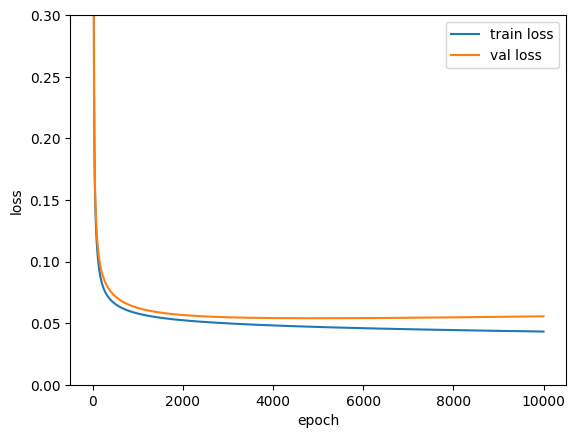

In [20]:
#손실 그래프 (손실값이 안정적으로 감소함)
plt.ylim(0,0.3)
plt.plot(single_layer.losses)
plt.plot(single_layer.val_losses)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train loss', 'val loss'])
plt.show()

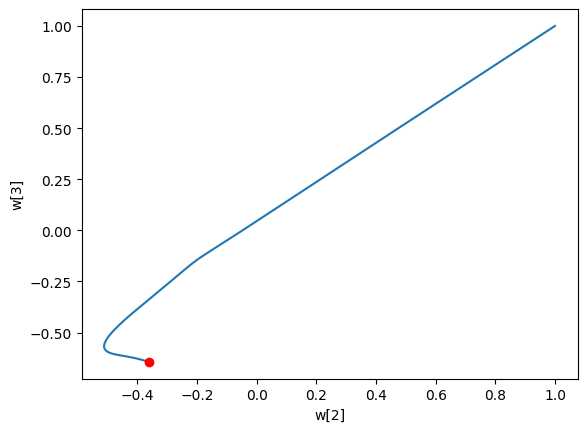

In [21]:
#가중치 그래프 (변화가 연속적임)
w2 = []
w3 = []
for w in single_layer.w_history :
  w2.append(w[2])
  w3.append(w[3])
plt.plot(w2, w3)
plt.plot(w2[-1], w3[-1], 'ro')
plt.xlabel('w[2]')
plt.ylabel('w[3]')
plt.show()

In [22]:
#2개의 층을 가진 신경망 구현하기
class DualLayer(SingleLayer) :

  def __init__(self, units=10, learning_rate=0.1, l1=0, l2=0) : #은닉층의 뉴런 개수 지정(units=)
    self.units = units #은닉층 뉴런 개수
    self.w1 = None #은닉층의 가중치
    self.b1 = None #은닉층의 절편
    self.w2 = None #출력층의 가중치
    self.b2 = None #출력층의 절편
    self.a1 = None #은닉층의 활성화 출력
    self.losses = [] #훈련세트 손실 저장
    self.val_losses = [] #검증세트 손실 저장
    self.lr = learning_rate #학습률
    self.l1 = l1 #L1 손실 규제
    self.l2 = l2 #L2 손실 규제

  def forpass(self, x) : #은닉층 통과하여 출력층의 정방향 계산까지 마친 z2 출력
    z1 = np.dot(x, self.w1) + self.b1 #은닉층 정방향 계산
    self.a1 = self.activation(z1) #은닉층 활성화함수
    z2 = np.dot(self.a1, self.w2) + self.b2 #출력층 정방향 계산
    return z2

  def backprop(self, x, err) : #오차 역전파
    m = len(x) #총 샘플 개수
    #출력층 가중치, 절편 그레이디언트 계산
    w2_grad = np.dot(self.a1.T, err) / m #출력층 가중치의 평균 그레이디언트 - a1*err 총합 / m
    b2_grad = np.sum(err) / m #출력층 절편의 평균 그레이디언트 - 1*err 총합 / m
    #은닉층 활성화함수(시그모이드) 그레이디언트 계산
    err_to_hidden = np.dot(err, self.w2.T) * self.a1 * (1 - self.a1) # 4) * 3) * 2)
    #은닉층 가중치, 절편 그레이디언트 계산
    w1_grad = np.dot(x.T, err_to_hidden) / m
    b1_grad = np.sum(err_to_hidden, axis=0) / m
    return w1_grad, b1_grad, w2_grad, b2_grad

  def init_weights(self, n_features) : #가중치 초기화
    self.w1 = np.ones( (n_features, self.units) ) #은닉층 가중치 - (특성개수,뉴런개수) 1로 된 행렬
    self.b1 = np.zeros(self.units) #은닉층 절편 - 뉴런개수만큼 0씩 지정
    self.w2 = np.ones( (self.units, 1) ) #출력층 가중치 - (뉴런개수,1) 1로 된 행렬
    self.b2 = 0 #출력층은 뉴런 1개니까,,,

  def fit(self, x, y, epochs=100, x_val=None, y_val=None) :
    y = y.reshape(-1,1)         #타깃을 행->열 벡터로 바꿈
    y_val = y_val.reshape(-1,1)
    m=len(x)                    #샘플 개수 저장
    self.init_weights(x.shape[1]) #가중치 초기화 (한 행의 크기 = 특성 개수)
    #epoch만큼 반복
    for i in range(epochs) :
      a = self.training(x,y,m) #A2까지 계산
      a = np.clip(a, 1e-10, 1-1e-10) #안전한 손실값 계산 위해 클리핑
      loss = np.sum( -( y*np.log(a) + (1-y)*np.log(1-a) ) ) #로그 손실
      self.losses.append( (loss + self.reg_loss()) / m )
      self.update_val_loss(x_val, y_val) #검증세트 손실 계산 및 누적

  def training(self, x, y, m) :
    z = self.forpass(x) #Z2(출력층 정방향 계산까지)
    a = self.activation(z) #A2
    err = -(y - a) #오차 계산
    w1_grad, b1_grad, w2_grad, b2_grad = self.backprop(x, err) #오차역전파->그레이디언트 계산
    #그레이디언트에서 패널티항 미분값 제외
    w1_grad += (self.l1 * np.sign(self.w1) + self.l2 * self.w1) / m
    w2_grad += (self.l2 * np.sign(self.w2) + self.l2 * self.w2) / m
    #은닉층 가중치,절편 업데이트
    self.w1 -= self.lr * w1_grad
    self.b1 -= self.lr * b1_grad
    #출력층 가중치, 절편 업데이트
    self.w2 -= self.lr * w2_grad
    self.b2 -= self.lr * b2_grad
    return a #A2

  def reg_loss(self) :
    return self.l1 * (np.sum(np.abs(self.w1)) + np.sum(np.abs(self.w2))) + \
           self.l2 / 2 * (np.sum(self.w1**2) + np.sum(self.w2**2))

In [23]:
#다층 신경망 모델 훈련해보기
dual_layer = DualLayer(l2=0.01)
dual_layer.fit(x_train_scaled, y_train, x_val=x_val_scaled, y_val=y_val, epochs=20000)
dual_layer.score(x_val_scaled, y_val)

np.float64(0.978021978021978)

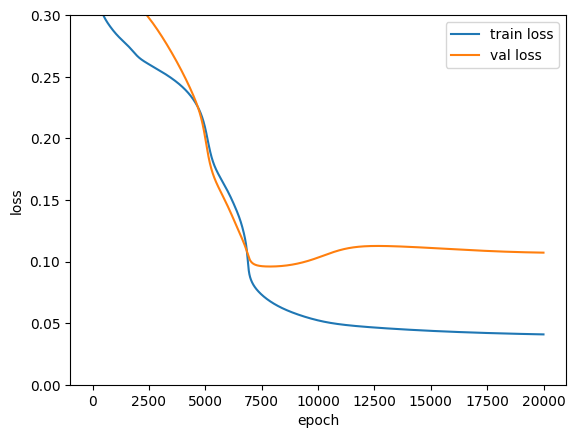

In [24]:
#훈련손실과 검증손실 그래프 분석하기
plt.ylim(0, 0.3)
plt.plot(dual_layer.losses)
plt.plot(dual_layer.val_losses)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train loss', 'val loss'])
plt.show()

In [25]:
#가중치 초기화 개선하기
class RandomInitNetwork(DualLayer) :

  def init_weights(self, n_features):
    np.random.seed(42)
    self.w1 = np.random.normal(0, 1, (n_features, self.units)) #???????
    self.b1 = np.zeros(self.units)
    self.w2 = np.random.normal(0, 1, (self.units, 1))
    self.b2 = 0

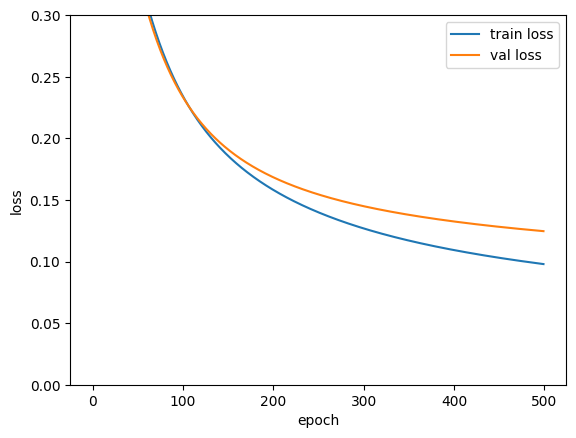

In [26]:
random_init_net = RandomInitNetwork(l2=0.01)
random_init_net.fit(x_train_scaled, y_train, x_val=x_val_scaled, y_val=y_val, epochs=500)

plt.ylim(0, 0.3)
plt.plot(random_init_net.losses)
plt.plot(random_init_net.val_losses)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train loss', 'val loss'])
plt.show()

In [31]:
#미니 배치 경사 하강법
class MinibatchNetwork(RandomInitNetwork) :

  def __init__(self, units=10, batch_size=32, learning_rate=0.1, l1=0, l2=0) :
    super().__init__(units, learning_rate, l1, l2) #나머지는 부모 클래스에서 갖다씀
    self.batch_size = batch_size #배치 크기

  def fit(self, x, y, epochs=100, x_val=None, y_val=None) :
    y_val = y_val.reshape(-1,1)
    self.init_weights(x.shape[1])
    np.random.seed(42)

    for i in range(epochs) :
      loss = 0
      #제러네이터 함수에서 반환한 미니배치 순환
      for x_batch, y_batch in self.gen_batch(x, y) :
        y_batch = y_batch.reshape(-1,1)
        m = len(x_batch)
        a = self.training(x_batch, y_batch, m)
        a = np.clip(a, 1e-10, 1-1e-10)
        loss += np.sum( -(y_batch*np.log(a) + (1-y_batch)*np.log(1-a)) )
      self.losses.append( (loss + self.reg_loss()) / len(x) )
      self.update_val_loss(x_val, y_val)

  def gen_batch(self, x, y) : #배치 나누는 함수
    length = len(x)
    bins = length // self.batch_size #미니 배치의 횟수
    if length % self.batch_size :
      bins += 1 #나누어 떨어지지 않을 때 -> 횟수+1
    indexes =np.random.permutation(np.arange(len(x))) #인덱스 섞기(샘플 순서 섞)
    x = x[indexes]
    y = y[indexes]
    for i in range(bins) : #횟수만큼
      start = self.batch_size * i
      end = self.batch_size * (i+1)
      yield x[start:end], y[start:end] #batch_size만큼 슬라이싱해서 반환

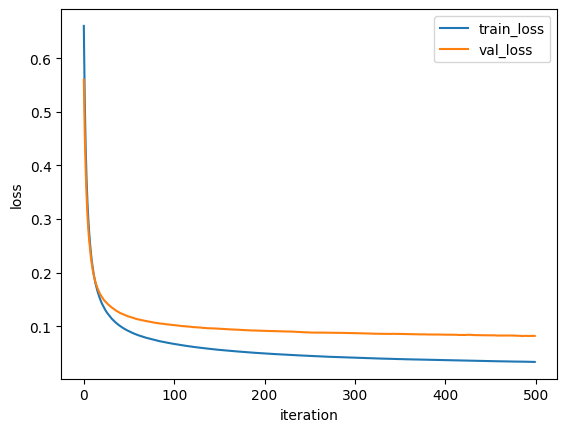

In [33]:
#배치 크기 32로 해보기
minibatch_net = MinibatchNetwork(l2=0.01, batch_size=32)
minibatch_net.fit(x_train_scaled, y_train, x_val=x_val_scaled, y_val=y_val, epochs=500)
minibatch_net.score(x_val_scaled, y_val)    #np.float64(0.978021978021978)

plt.plot(minibatch_net.losses)
plt.plot(minibatch_net.val_losses)
plt.ylabel('loss')
plt.xlabel('iteration')
plt.legend(['train_loss', 'val_loss'])
plt.show()

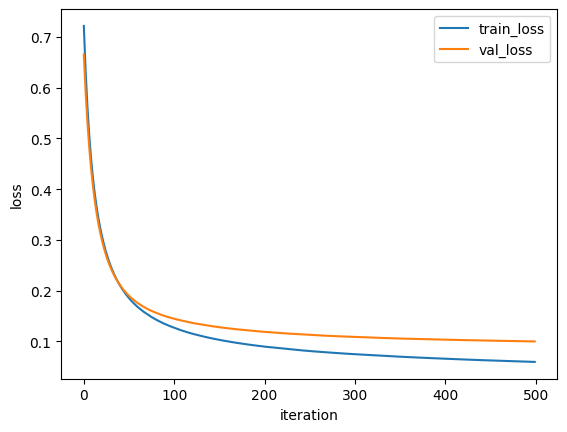

In [38]:
#배치 크기 128로 해보기
minibatch_net = MinibatchNetwork(l2=0.01, batch_size=128)
minibatch_net.fit(x_train_scaled, y_train, x_val=x_val_scaled, y_val=y_val, epochs=500)
minibatch_net.score(x_val_scaled, y_val)    #np.float64(0.978021978021978)

plt.plot(minibatch_net.losses)
plt.plot(minibatch_net.val_losses)
plt.ylabel('loss')
plt.xlabel('iteration')
plt.legend(['train_loss', 'val_loss'])
plt.show()

In [40]:
#사이킷런을 이용해 다층 신경망 훈련하기
from sklearn.neural_network import MLPClassifier #분류 작업
mlp = MLPClassifier(hidden_layer_sizes=(10,), activation='logistic', #은닉층 수와 뉴런의 개수, 활성화함수=시그모이드 함수
                    solver='sgd', alpha=0.01, batch_size=32,         #경사하강법 알고리즘 종류: 확률적~, 규제(l2만 지원)=0.01, 배치 크기 32
                    learning_rate_init=0.1, max_iter=500)            #학습률 0.1, 에포크 횟수 500

mlp.fit(x_train_scaled, y_train)
mlp.score(x_val_scaled, y_val)

0.989010989010989